In [1]:
# imports 

import numpy as np
import matplotlib.pyplot as plt

import os
path_base = os.getcwd().split('Dragonfly44_SFH')[0]  # gross, but works

In [2]:
path_data = path_base+ "Dragonfly44_SFH/data/"
obs_file = path_data+"Dragonfly44/obs_phot_specKCWI_sigma110.h5"

specKCWI_file_unsmoothed = path_data+"Dragonfly44/Villaume2022_KCWI/df44_optimal_unsmoothed_new_bad_pix_interp.dat"
specKCWI_file_smoothed = path_data+"Dragonfly44/Villaume2022_KCWI/df44_optimal_cl_avg_100kms_new_bad_pix_interp_fixed_broadening.dat"

zobs = 0.02142


# smooth vs unsmoothed KCWI spectrum

In [3]:
slope, intercept = 1.959362764878707e-12, 6.328363461638278e-10
fact = 1e-8

x,y,ey,_,_ = np.loadtxt(specKCWI_file_unsmoothed, unpack=True)
obs_unsmoothed = dict( wavelength=x, spectrum=y, unc=ey, fact=fact)

x,y,ey,_,_ = np.loadtxt(specKCWI_file_smoothed, unpack=True)
obs_smooth = dict( wavelength=x, spectrum=y, unc=ey, sigma_smooth=100, smoothtype='vel', fact=fact)

### identify different regions of the spectrum
- This was used during the testing phase where specific regions of the spectrum were masked
- Results of the SED-fitting were compared for different inputs (different masking schemes)
- In the end, all of the spectrum was fit except about 4733 A 

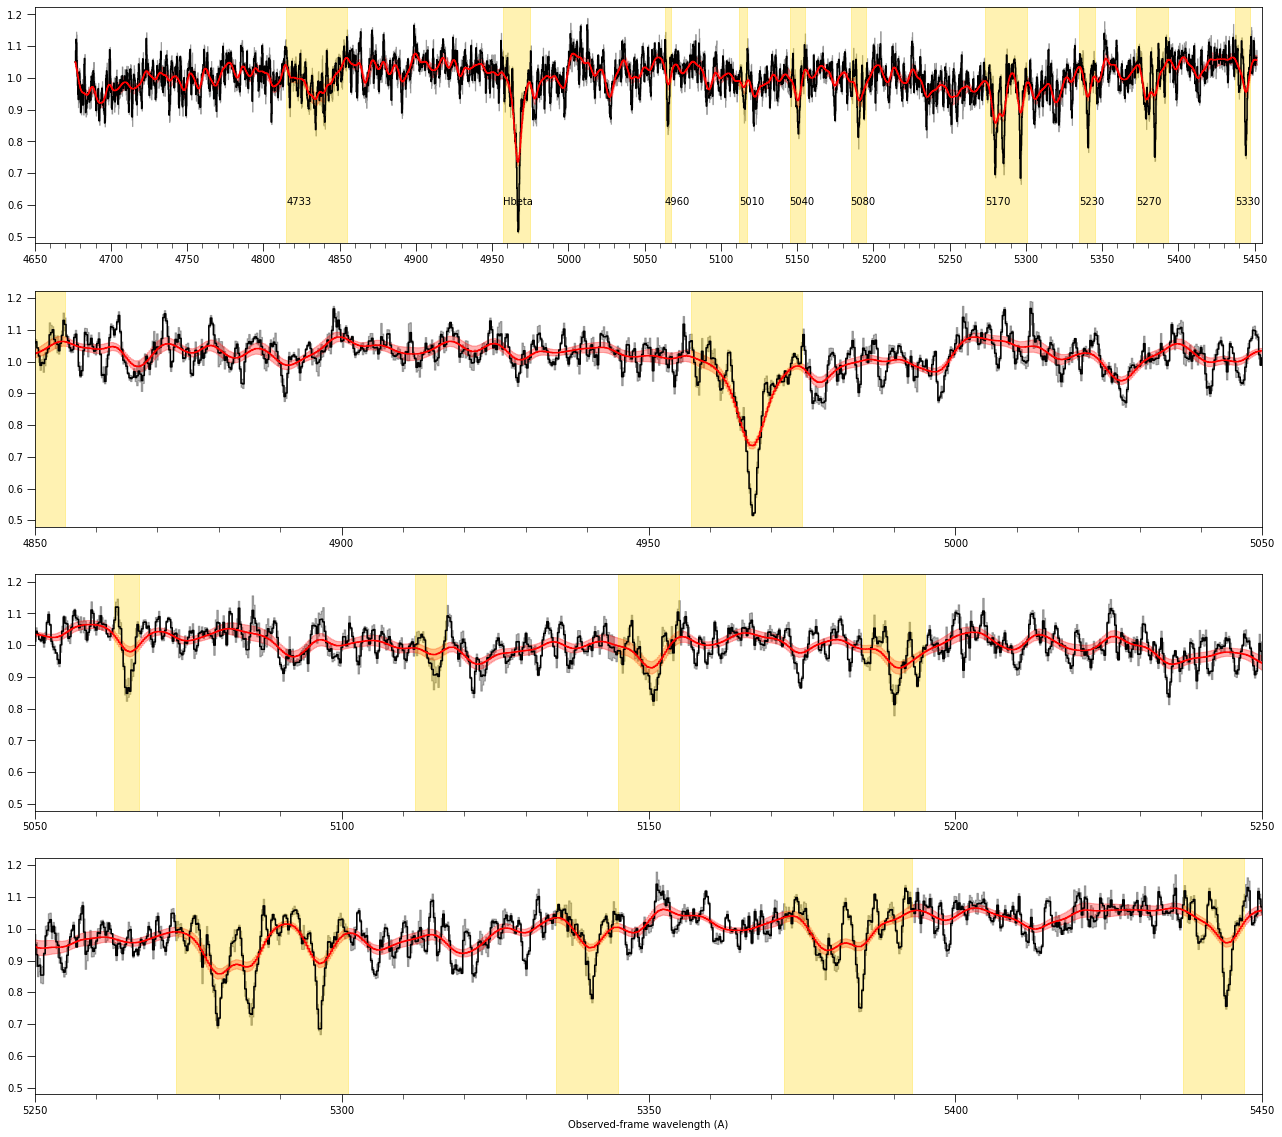

In [4]:
#
fig, axs = plt.subplots(4,1,figsize=(22,20))
ax1,ax1a,ax1b,ax1c = axs

for ii,ax in enumerate(axs):

    x,y,ey = [ np.copy( obs_unsmoothed[key] ) for key in ['wavelength','spectrum','unc'] ]
    ax.fill_between( x, y-ey, y+ey, color='k', alpha=0.3, step='post' )
    ax.step( x, y, color='k', where='post' )
    
    x,y,ey = [ np.copy( obs_smooth[key] ) for key in ['wavelength','spectrum','unc'] ]
    ax.fill_between( x, y-ey, y+ey, color='r', alpha=0.3, step='post' )
    ax.step( x, y, color='r', where='post' )
    
    for x1,x2,label in [[4815,4855,'4733'], [5063,5067,'4960'], [5112,5117,"5010"], [5145,5155,"5040"], [5185,5195,"5080"], \
                        [5273,5301,"5170"], [5335,5345,"5230"], [5372,5393,"5270"], [5437,5447,"5330"], [4957,4975,"Hbeta"] ]:
        ax.axvspan( x1,x2, color='gold', alpha=0.3 )
        if ii==0: ax.text( x1, 0.6, label,  color='k')

import matplotlib.ticker as ticker   
for ax in axs:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.tick_params(direction='out', length=8, which='major')
    ax.tick_params(direction='out', length=5, which='minor')

ax1.set_xlim(4650,5455)    
ax1a.set_xlim(4850,5050)    
ax1b.set_xlim(5050,5250)    
ax1c.set_xlim(5250,5450) 

axs[-1].set_xlabel('Observed-frame wavelength (A)')
plt.show()

### plot with line lists

In [5]:
import pandas as pd
lines_FeI = pd.read_csv( path_data+"linelists/linelist_FeI_gt5000.csv")
lines_MgI = pd.read_csv( path_data+"linelists/linelist_MgI.csv")

lines_FeI.rename( columns={"obs_wl_air(A)":"wline"}, inplace=True)
lines_MgI.rename( columns={"obs_wl_air(A)":"wline"}, inplace=True)

lines_FeI['intens_float'] = np.full( len(lines_FeI), np.nan )
for idx in lines_FeI.index.values:
    try: lines_FeI.loc[idx,'intens_float'] = float( lines_FeI.loc[idx,'intens'] )
    except: pass

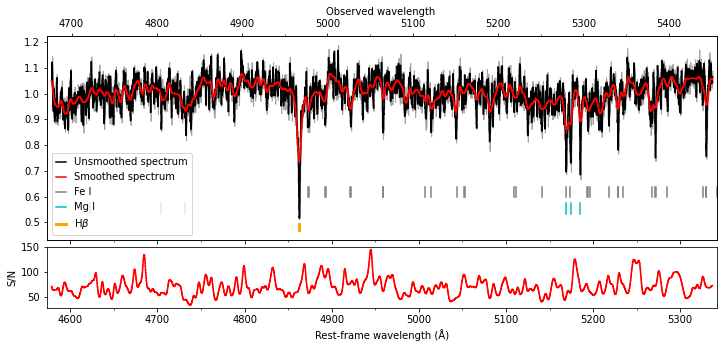

In [6]:
#
fig, (ax,ax2) = plt.subplots(2,1,figsize=(12,5), gridspec_kw={"height_ratios":[1,0.3]}, sharex=True)


x,y,ey = [ np.copy( obs_unsmoothed[key] ) for key in ['wavelength','spectrum','unc'] ]
x /= (1.+zobs)
ax.fill_between( x, y-ey, y+ey, color='k', alpha=0.3, step='post' )
l1, = ax.step( x, y, color='k', where='post', label="Unsmoothed spectrum" )

x,y,ey = [ np.copy( obs_smooth[key] ) for key in ['wavelength','spectrum','unc'] ]
x /= (1.+zobs)
ax.fill_between( x, y-ey, y+ey, color='r', alpha=0.3, step='post' )
l2, = ax.step( x, y, color='r', where='post', label='Smoothed spectrum' )

ax2.step( x, (y/ey), color='r', where='post', label='Smoothed spectrum')

for xx in [4862.71,]:
    l5 = ax.axvline( xx, ymin=0.05,ymax=0.08, color='orange', lw=3)

for xx in lines_FeI.query('intens_float>25000')['wline']:
    l3 = ax.axvline( xx*1.000293, ymin=0.21,ymax=0.21+0.05, color='0.5')

for xx in lines_MgI['wline']:
    l4 = ax.axvline( xx*1.000293, ymin=0.13,ymax=0.13+0.05, color='c')

ax.legend( [l1,l2,l3,l4,l5], ['Unsmoothed spectrum','Smoothed spectrum',"Fe I","Mg I",r"H$\beta$"],
            handlelength=1)   
ax.set_xlim( np.min(x)-5, np.max(x)+5 )

ylim = ax.get_ylim()
ax.set_ylim( 0.9*ylim[0], ylim[1] )

xlim = ax.get_xlim()
xlim_rf = np.array(xlim)*(1+zobs)
axt = ax.twiny()
axt.set_xlim( xlim_rf )
axt.set_xlabel(u"Observed wavelength ")
axt.set_xticks( np.arange( 4700,5400+1, 50), minor=True ) 
ax.set_xticks( np.arange( 4600,5300+1, 50), minor=True ) 

# ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
# ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
# ax.tick_params(direction='out', length=8, which='major')
# ax.tick_params(direction='out', length=5, which='minor')
#     

ax2.set_xlabel(u'Rest-frame wavelength (\u00c5)')
ax2.set_ylabel(u'S/N')

fig.subplots_adjust( hspace=0.05)
# plt.savefig( path_fig+"spectrum_with_lines.png", **saveparams)
plt.show()

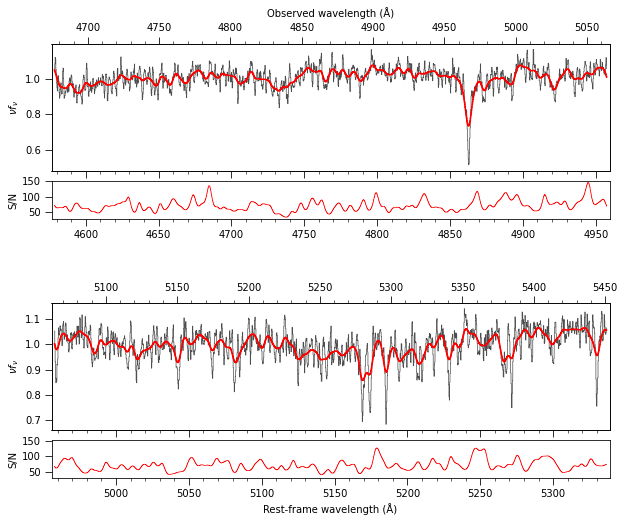

In [7]:
#
fig, axs = plt.subplots(2*2+1,1,figsize=(10,8), gridspec_kw={"height_ratios":[1,0.3,0.5,1,0.3]}, sharex=False)
axs[2].axis('off')


x,y,ey = [ np.copy( obs_unsmoothed[key] ) for key in ['wavelength','spectrum','unc'] ]
x /= (1.+zobs)
isplit = int( len(x)/2. )
iwave = x[isplit]

for i,slc in [ [0,slice(0,isplit)], [3,slice(isplit,-1)] ]:
    ax = axs.flatten()[i]
    
#     ax.fill_between( x[slc], (y-ey)[slc], (y+ey)[slc], color='k', alpha=0.3, step='post' )
    l1, = ax.step( x[slc], y[slc], color='0.3', lw=0.7, where='post', label="Unsmoothed spectrum" )

x,y,ey = [ np.copy( obs_smooth[key] ) for key in ['wavelength','spectrum','unc'] ]
x /= (1.+zobs)
isplit = np.argmin(np.abs( x - iwave))

for i,slc in [ [0,slice(0,isplit)], [3,slice(isplit,-1)] ]:
    ax, ax2 = axs.flatten()[i], axs.flatten()[i+1]

#     ax.fill_between( x[slc], (y-ey)[slc], (y+ey)[slc], color='r', alpha=0.3, step='post' )
    l2, = ax.step( x[slc], y[slc], color='r', where='post', label='Smoothed spectrum' )

    ax2.step( x[slc], (y/ey)[slc], color='r', where='post', lw=0.7, label='Smoothed spectrum')
    
    ax.set_xlim( (x[slc])[0]-2, (x[slc])[-1]+2)
    ax2.set_xlim( ax.get_xlim() )

# for xx in [4862.71,]:
#     l5 = ax.axvline( xx, ymin=0.05,ymax=0.08, color='orange', lw=3)

# for xx in lines_FeI.query('intens_float>25000')['wline']:
#     l3 = ax.axvline( xx*1.000293, ymin=0.21,ymax=0.21+0.05, color='0.5')

# for xx in lines_MgI['wline']:
#     l4 = ax.axvline( xx*1.000293, ymin=0.13,ymax=0.13+0.05, color='c')

# ax.legend( [l1,l2,l3,l4,l5], ['Unsmoothed spectrum','Smoothed spectrum',"Fe I","Mg I",r"H$\beta$"],
#             handlelength=1)   

axs[-1].set_ylim( axs[1].get_ylim() )

for i in [3,0]:
    ax = axs[i]
    xlim = ax.get_xlim()
    xlim_rf = np.array(xlim)*(1+zobs)
    axt = ax.twiny()
    axt.set_xlim( xlim_rf )
    axt.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    axt.xaxis.set_major_locator(ticker.MultipleLocator(50))
    axt.tick_params(direction='out', length=7, which='major')
    axt.tick_params(direction='out', length=3, which='minor')
    
axt.set_xlabel(u"Observed wavelength (\u00c5)", labelpad=6)    

for ax in axs:
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(10))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
    ax.tick_params(direction='out', length=7, which='major')
    ax.tick_params(direction='out', length=3, which='minor')
#     

axs[-1].set_xlabel(u'Rest-frame wavelength (\u00c5)')
[ axs[i].set_ylabel(u'S/N') for i in [1,4] ]
[ axs[i].set_ylabel(r'$\nu f_\nu$') for i in [0,3] ]
[ axs[i].set_xticklabels([]) for i in [0,3] ]

fig.subplots_adjust( hspace=0.13)
plt.show()

# plot smoothed spectrum and photometry

In [8]:
from Dragonfly44_SFH.fitting.input.param_fit_setup import build_obs
obs = build_obs( file_data=obs_file )

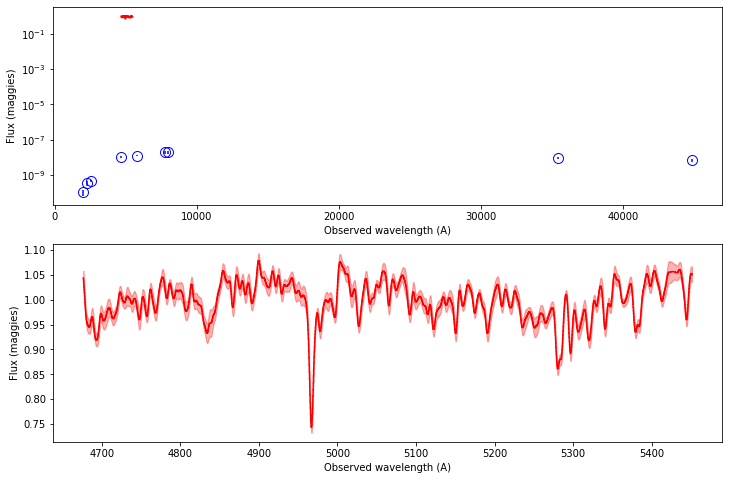

In [9]:
#
fig, axs = plt.subplots(2,1,figsize=(12,8))
ax1,ax2 = axs

ax1.errorbar( obs['phot_wave'], obs['maggies'], yerr=obs['maggies_unc'], fmt=' ', color='b', marker='o', mec='b', mfc='None', ms=10)
ax1.set_yscale("log")

for ax in axs:
    ax.fill_between( obs['wavelength'], obs['spectrum']-obs['unc'], obs['spectrum']+obs['unc'], color='r', alpha=0.3, step='post' )
    ax.step( obs['wavelength'], obs['spectrum'], color='r', where='post' )

[ ax.set_xlabel('Observed wavelength (A)') for ax in axs ]
[ ax.set_ylabel('Flux (maggies)') for ax in axs    ]
plt.show()